In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn

from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report
from tableone import TableOne

%matplotlib inline
rcParams['figure.figsize'] = 10, 8
sb.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

In [2]:
eicu_lr = pd.read_csv("GeneratedFiles/Databases/eicu_lr.csv", sep=';', encoding='ISO-8859-1')
eicu_rf = pd.read_csv("GeneratedFiles/Databases/eicu_rf.csv", sep=';', encoding='ISO-8859-1')
eicu_pls = pd.read_csv("GeneratedFiles/Databases/eicu_pls.csv", sep=';', encoding='ISO-8859-1')

* Cargo solo las variables seleccionadas como importantes

In [3]:
lr_important=pd.read_csv("GeneratedFiles/ImportantVariables/lr_important.csv", sep=',', encoding='ISO-8859-1')
list_lr_important=list(lr_important['colummn'].values)
list_lr_important.append('lactate_label')

rf_important=pd.read_csv("GeneratedFiles/ImportantVariables/rf_important.csv", sep=',', encoding='ISO-8859-1')
list_rf_important=list(rf_important['colummn'].values)
list_rf_important.append('lactate_label')

pls_important=pd.read_csv("GeneratedFiles/ImportantVariables/pls_important.csv", sep=',', encoding='ISO-8859-1')
list_pls_important=list(pls_important['colummn'].values)
list_pls_important.append('lactate_label')

In [4]:
eicu_lr = eicu_lr[list_lr_important]

eicu_rf = eicu_rf[list_rf_important]

eicu_pls = eicu_pls[list_pls_important]

# Logistic Regression with CV
***

- eicu

In [5]:
print("--------------------------")

print("Logistic Regression at eicu with features selected")

from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score


--------------------------
Logistic Regression at eicu with features selected


In [6]:
from sklearn.model_selection import cross_validate


eicu_lr_2 = eicu_lr.copy()
categorical=eicu_lr[list(eicu_lr.columns[eicu_lr.dtypes==np.object])].drop(['lactate_label'],axis=1)
for col in categorical:
    eicu_lr[col] = np.where(eicu_lr[col]=='Yes',1,0)

eicu_lr['lactate_label'] = np.where(eicu_lr['lactate_label'] == 'high',1,0)

lr = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
y_lr = eicu_lr['lactate_label']
x_lr= eicu_lr.drop(['lactate_label'],axis=1)

cv_model = cross_validate(lr, x_lr, y_lr, cv=5, return_train_score=True, return_estimator=True, scoring = ['accuracy', 'recall', 'roc_auc'])
scores=pd.DataFrame(cv_model['test_accuracy'])
scores.columns=['score']
scores = scores.sort_values('score',ascending=False)
print("Scores of Cross Validation")
print(scores)

best_estimator = cv_model['estimator'][scores.iloc[0].name]

print('roc '+str(cv_model['test_roc_auc'][scores.iloc[0].name]))
print('recall '+str(cv_model['test_recall'][scores.iloc[0].name]))

Scores of Cross Validation
      score
1  0.786451
0  0.777941
4  0.774336
2  0.771723
3  0.755162
roc 0.873600624837282
recall 0.7884057971014493


Importance of features for eicu after CV


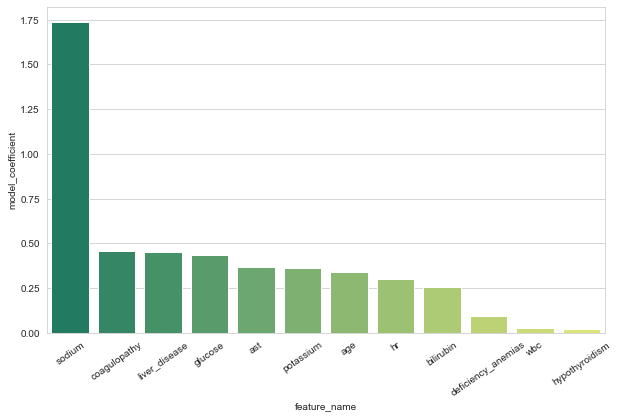

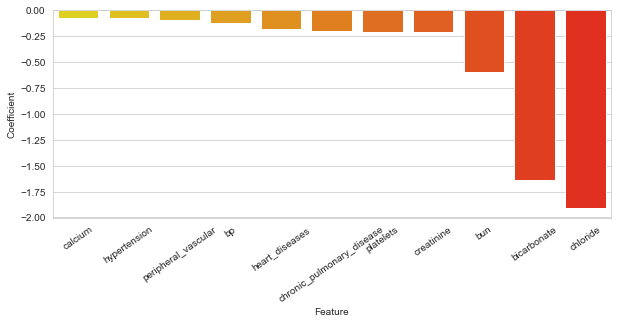

In [7]:
print("Importance of features for eicu after CV") 
# Get the models coefficients (and top 5 and bottom 5)
logReg_coeff_lr_eicu = pd.DataFrame({'feature_name': x_lr.columns.values, 'model_coefficient': best_estimator.coef_.transpose().flatten()})
logReg_coeff_lr_eicu = logReg_coeff_lr_eicu.sort_values('model_coefficient',ascending=False)
logReg_coeff_top = logReg_coeff_lr_eicu.head(sum(logReg_coeff_lr_eicu['model_coefficient']>0))
logReg_coeff_bottom = logReg_coeff_lr_eicu.tail(sum(logReg_coeff_lr_eicu['model_coefficient']<0))


# Plot top 5 coefficients
plt.figure().set_size_inches(10, 6)
fg3 = sb.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_top, palette="summer")
fg3.set_xticklabels(rotation=35, labels=logReg_coeff_top.feature_name)
# Plot bottom 5 coefficients
plt.figure().set_size_inches(10,6)
fg4 = sb.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_bottom, palette="autumn_r")
fg4.set_xticklabels(rotation=35, labels=logReg_coeff_bottom.feature_name)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.subplots_adjust(bottom=0.4)
# plt.savefig('figure_4.png')

In [8]:
print("Classification")

from sklearn import metrics
pred=best_estimator.predict(x_lr)
classes_lr=np.where(np.logical_and(pred==1,y_lr.values==1),'TP',
         np.where(np.logical_and(pred==1,y_lr.values==0),'FP',
                  np.where(np.logical_and(pred==0,y_lr.values==0), 'TN',
                           np.where(np.logical_and(pred==0,y_lr.values==1),'FN','MAL'))))
import scipy
print(scipy.stats.itemfreq(classes_lr))


Classification
[['FN' '405']
 ['FP' '341']
 ['TN' '1330']
 ['TP' '1318']]


In [9]:
logReg_coeff_lr_eicu.to_csv('GeneratedFiles/ImportantVariables/coef_lr_eicu_2.csv', sep=';', header = False, index=False)

# RandomForest with CV
***

- eicu

In [10]:
print("--------------------------")

print("Random Forest at eicu for feature selection")


--------------------------
Random Forest at eicu for feature selection


Score for CV
      score
4  0.772861
1  0.755523
0  0.742647
3  0.740413
2  0.731959
roc 0.8437717588079655
recall 0.747093023255814


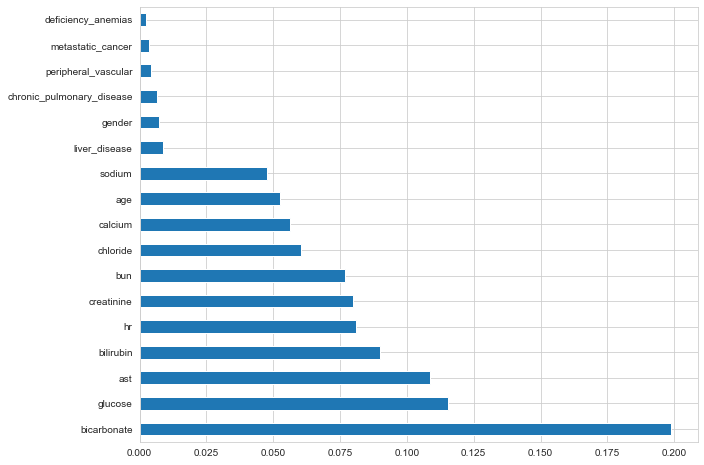

In [11]:
from sklearn.model_selection import cross_validate
eicu_rf_2 = eicu_rf.copy()

eicu_rf_3 = eicu_rf_2.copy()

eicu_rf_2['gender'] = np.where(eicu_rf_2['gender']=='M',1,0)

categorical=eicu_rf_2[list(eicu_rf_2.columns[eicu_rf_2.dtypes==np.object])].drop(['lactate_label'],axis=1)
for col in categorical:
    eicu_rf_2[col] = np.where(eicu_rf_2[col]=='Yes',1,0)

eicu_rf_2['lactate_label'] = np.where(eicu_rf_2['lactate_label'] == 'high',1,0)

rf = RandomForestClassifier(n_estimators=200, random_state=0,max_depth=10, n_jobs=-1)
y_rf = eicu_rf_2['lactate_label']
x_rf= eicu_rf_2.drop(['lactate_label'],axis=1)


cv_model = cross_validate(rf, x_rf, y_rf, cv=5, return_train_score=True, return_estimator=True, scoring = ['accuracy', 'recall', 'roc_auc'])
scores=pd.DataFrame(cv_model['test_accuracy'])
scores.columns=['score']
scores = scores.sort_values('score',ascending=False)
print("Score for CV")
print(scores)

bestRF = cv_model['estimator'][scores.iloc[0].name]
plt.figure(103)
importances = pd.Series(bestRF.feature_importances_,x_rf.columns)
importances.nlargest(20).plot(kind='barh')

print('roc '+str(cv_model['test_roc_auc'][scores.iloc[0].name]))
print('recall '+str(cv_model['test_recall'][scores.iloc[0].name]))

In [12]:
for var in importances.index:
    if var in list(categorical.columns):
        high = sum(eicu_rf_2.loc[eicu_rf_2['lactate_label']==1][var] == 1)
        low = sum(eicu_rf_2.loc[eicu_rf_2['lactate_label']==0][var] == 1)
        if(high<=low):
            importances[var] = -importances[var]
    else:
        high = np.mean(eicu_rf_2.loc[eicu_rf_2['lactate_label']==1][var])
        low = np.mean(eicu_rf_2.loc[eicu_rf_2['lactate_label']==0][var])
        if(high<=low):
            importances[var] = -importances[var]

Importance of features for eicu after CV


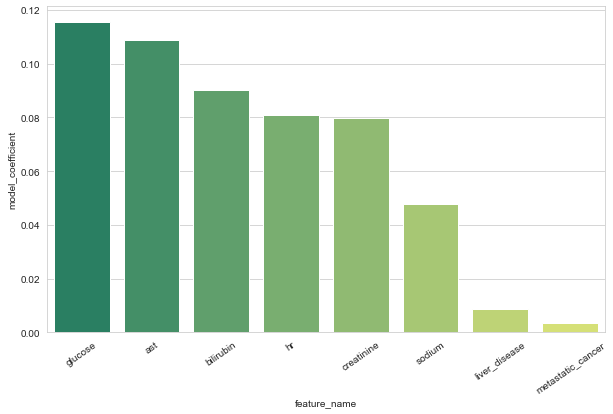

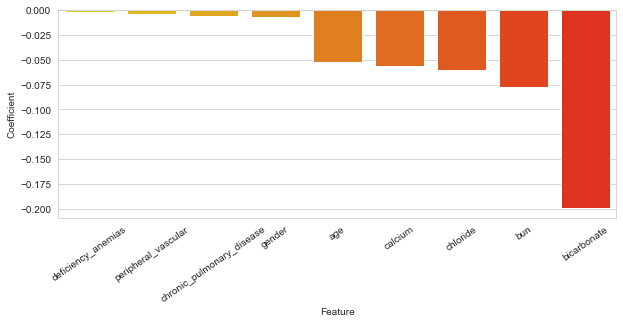

In [13]:
print("Importance of features for eicu after CV") 
    
# Get the models coefficients (and top 5 and bottom 5)
logReg_coeff_rf_eicu = pd.DataFrame({'feature_name': x_rf.columns.values, 'model_coefficient': importances})
logReg_coeff_rf_eicu = logReg_coeff_rf_eicu.sort_values('model_coefficient',ascending=False)
logReg_coeff_top = logReg_coeff_rf_eicu.head(sum(logReg_coeff_rf_eicu['model_coefficient']>0))
logReg_coeff_bottom = logReg_coeff_rf_eicu.tail(sum(logReg_coeff_rf_eicu['model_coefficient']<0))


# Plot top 5 coefficients
plt.figure(100).set_size_inches(10, 6)
fg3 = sb.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_top, palette="summer")
fg3.set_xticklabels(rotation=35, labels=logReg_coeff_top.feature_name)
# Plot bottom 5 coefficients
plt.figure(101).set_size_inches(10,6)
fg4 = sb.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_bottom, palette="autumn_r")
fg4.set_xticklabels(rotation=35, labels=logReg_coeff_bottom.feature_name)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.subplots_adjust(bottom=0.4)
# plt.savefig('figure_4.png')

In [14]:
print("Classification")
from sklearn import metrics
pred=bestRF.predict(x_rf)
classes_rf=np.where(np.logical_and(pred==1,y_rf.values==1),'TP',
         np.where(np.logical_and(pred==1,y_rf.values==0),'FP',
                  np.where(np.logical_and(pred==0,y_rf.values==0), 'TN',
                           np.where(np.logical_and(pred==0,y_rf.values==1),'FN','MAL'))))
import scipy
print(scipy.stats.itemfreq(classes_rf))


Classification
[['FN' '213']
 ['FP' '124']
 ['TN' '1547']
 ['TP' '1510']]


In [15]:
logReg_coeff_rf_eicu.to_csv('GeneratedFiles/ImportantVariables/coef_rf_eicu_2.csv', sep=';', header = False, index=False)


# ORTHOGONAL PLS

In [16]:
print("--------------------------")

print("Orthogonal PLS at eicu for feature selection")


categorical=eicu_pls[list(eicu_pls.columns[eicu_pls.dtypes==np.object])].drop(['lactate_label'],axis=1)
for col in categorical:
    eicu_pls[col] = np.where(eicu_pls[col]=='Yes',1,0)

eicu_pls['lactate_label'] = np.where(eicu_pls['lactate_label'] == 'high',1,0)

y_lr = eicu_pls['lactate_label']
x_lr= eicu_pls.drop(['lactate_label'],axis=1)


# x_lr=x_lr.drop('classes', axis=1)
y_lr = np.array(y_lr, dtype=int)

--------------------------
Orthogonal PLS at eicu for feature selection


In [17]:

from sklearn.model_selection import KFold
from pyopls import OPLS
from sklearn.cross_decomposition import PLSCanonical, PLSRegression, CCA
from sklearn import metrics

x_pls = x_lr
kf = KFold(n_splits=5)
accuracy_pls_componentes=list()
roc_pls_componentes=list()
coefs_componentes = list()
recall_componentes = list()
for train_index, test_index in kf.split(eicu_pls):
    X_train = x_pls.iloc[train_index]
    X_test = x_pls.iloc[test_index]
    y_train, y_test = y_lr[train_index], y_lr[test_index]
    opls = OPLS(3,scale=False)
    Z = opls.fit(X_train, y_train)
    Z_trans= Z.transform(X_train)
    pls2 = PLSRegression(1,scale=False)
    pls2.fit(Z_trans, y_train)
    Z_trans_test = Z.transform(X_test)
    predict=pls2.predict(Z_trans_test)
    predict_roc=np.where(predict>1,1,np.where(predict<0,0,predict))
    roc_pls_componentes.append(metrics.roc_auc_score(y_test,predict_roc))
    predict_auc=np.where(predict>=0.5,1,0)
    accuracy_pls_componentes.append(metrics.accuracy_score(y_test,predict_auc))
    recall_componentes.append(metrics.recall_score(y_test,predict_auc))
    coefs_componentes.append(pls2.coef_)

print(accuracy_pls_componentes)
print(roc_pls_componentes)

scores=pd.DataFrame(accuracy_pls_componentes)
scores.columns=['score']
scores = scores.sort_values('score',ascending=False)
print("Score for CV")
print(scores)


print('roc '+str(roc_pls_componentes[scores.iloc[0].name]))
print('recall '+str(recall_componentes[scores.iloc[0].name]))


[0.7731958762886598, 0.7673048600883653, 0.7673048600883653, 0.7363770250368189, 0.7610619469026548]
[0.8370311329465672, 0.8453409170704305, 0.8468946847831746, 0.8136509589516618, 0.843432365636313]
Score for CV
      score
0  0.773196
1  0.767305
2  0.767305
4  0.761062
3  0.736377
roc 0.8370311329465672
recall 0.7075471698113207


Importance of features for eicu after CV


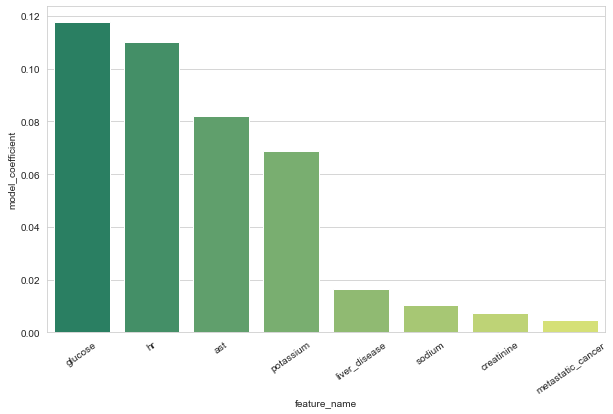

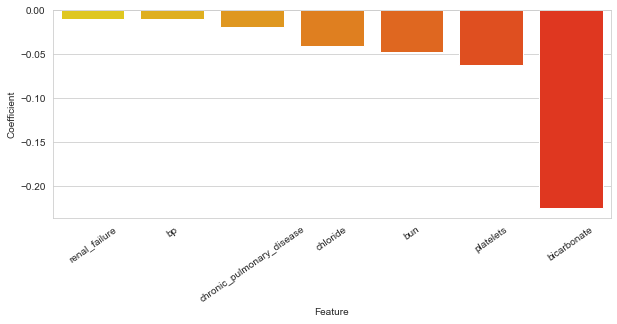

In [18]:
print("Importance of features for eicu after CV") 
feature_importances_ = coefs_componentes[scores.iloc[0].name]
# Get the models coefficients (and top 5 and bottom 5)
logReg_coeff_pls_eicu = pd.DataFrame({'feature_name': x_pls.columns.values, 'model_coefficient': feature_importances_.transpose().flatten()})
logReg_coeff_pls_eicu = logReg_coeff_pls_eicu.sort_values('model_coefficient',ascending=False)
logReg_coeff_top = logReg_coeff_pls_eicu.head(sum(logReg_coeff_pls_eicu['model_coefficient']>0))
logReg_coeff_bottom = logReg_coeff_pls_eicu.tail(sum(logReg_coeff_pls_eicu['model_coefficient']<0))


# Plot top 5 coefficients
plt.figure().set_size_inches(10, 6)
fg3 = sb.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_top, palette="summer")
fg3.set_xticklabels(rotation=35, labels=logReg_coeff_top.feature_name)
# Plot bottom 5 coefficients
plt.figure().set_size_inches(10,6)
fg4 = sb.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_bottom, palette="autumn_r")
fg4.set_xticklabels(rotation=35, labels=logReg_coeff_bottom.feature_name)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.subplots_adjust(bottom=0.4)
# plt.savefig('figure_4.png')

In [19]:
logReg_coeff_pls_eicu.to_csv('GeneratedFiles/ImportantVariables/coef_pls_eicu_2.csv', sep=';', header = False, index=False)